# 영업이익이 전분기 대비 상승했을경우 주식을 사면 profit 이 얼마나 될까?
   * 보유종목, 보유기간에 따른 profit 알아보기

In [1]:
import requests
import re
import FinanceDataReader as fdr
import os
from io import BytesIO
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.font_manager as fn
import dart_fss as dart
import OpenDartReader #https://github.com/FinanceData/OpenDartReader/tree/f6c303b699e96c2690da2000e96858acd86c5de8
from datetime import date
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
from tqdm import trange

## api_key 신청! 
* 하루에 1만건 제한
* 분당 웹사이트 요청횟수가 100건이 넘어가면 IP 차단

In [ ]:
api_key = ""
dart = OpenDartReader(api_key)

* 시가총액 상위 10개 종목
* 삼성전자우, KAKAO 제외

In [2]:
corp_list = ['005930', '000660','207940','035420','068270','051910','006400','005380']
corp_name_list = ['Samsung Electronics','Hynix','Samsung Biologics','NAVER','Celltrion','LG Chemical','Samsung SDI','Hyundai']

## rcept_no, period, dcm_no 구하는 함수

In [4]:
def number(corp_code,corp_name):
    print(corp_code, corp_name)
    url = "https://opendart.fss.or.kr/api/list.xml?crtfc_key={}&page_count=100&corp_code={}&bgn_de=20100101&pblntf_detail_ty=A001&pblntf_detail_ty=A002&pblntf_detail_ty=A003".format(api_key,corp_code)
    
    period = []
    dcm_no_list = []
    data = {}
    
    r = requests.get(url)
    web = r.content.decode('UTF-8')
    
    
    rcept_no_list = re.findall(r'<rcept_no>(.*?)</rcept_no>',web)
    rcept_date_list = re.findall(r'<rcept_dt>(.*?)</rcept_dt>',web)
    period_list = re.findall(r'<report_nm>(.*?)</report_nm>',web)
    

    for i in period_list:
        a = i[-8:-1]
        period.append(a)
    period_list = period
    
    for rcp_no in tqdm(rcept_no_list):
        url = "http://dart.fss.or.kr/dsaf001/main.do?rcpNo={}".format(rcp_no)
        resp = requests.get(url)
        webpage = resp.content.decode('UTF-8')
        dcm_no = re.findall(r"{}', '(.*?)',".format(rcp_no),webpage)[0]
        dcm_no_list.append(dcm_no)
        time.sleep(1)
      
    data['period'] = period_list
    data['rcept_no'] = rcept_no_list
    data['rcept_date'] = rcept_date_list
    data['dcm_no'] = dcm_no_list

    df = pd.DataFrame(data)
    df = df.sort_values(['period'], ascending=False)
    df.reset_index(drop=True, inplace=True)
    
 
    a = []
    for i in range(len(df['period'])-1):
        #print(i)
        if df['period'][i] == df['period'][i+1]:
            if df['rcept_date'][i] > df['rcept_date'][i+1]:
                #print(df['period'][i])
                a.append(i)
                #df = df.drop(index=i)
            else:
                #print(df['period'][i+1])
                #df = df.drop(index=i+1)
                a.append(i+1)
    for i in a:
        df = df.drop(index=i)
    df.reset_index(drop=True, inplace=True) 
    
    df = df.set_index('period',drop=True)
    df.to_excel('{}.xlsx'.format(corp_name))



### 각각의 종목에 대해서 period, rcp_no, dcm_no, rcept_date 구하기

In [ ]:
for corp_code, corp_name in tqdm(zip(corp_list,corp_name_list)):
    number(corp_code,corp_name)

## 미리 크롤링한 period, rcp_no, dcm_no 를 가지고 사업보고서 다운받는 함수

In [ ]:
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36"

def download_excel(period, rcp_no, dcm_no, company):
    url = "http://dart.fss.or.kr/pdf/download/excel.do?rcp_no=" + rcp_no + "&dcm_no=" + dcm_no + "&lang=ko"
    resp = requests.get(url, headers = {"user-agent": user_agent})
    #table = BytesIO(resp.content)
    pocket = ["연결 손익계산서"]
    for sheet in pocket:
        table = BytesIO(resp.content)
        data = pd.read_excel(table,sheet_name=2,skiprows=5)
        data.to_excel(str(period) + company + sheet + ".xlsx", encoding="euc-kr")

## 사업보고서 (재무재표) excel 다운로드 (~2011)
    * 삼성바이오로직스는 2017년 상장으로 인해서 중간에 오류가 남
    * 오류 나면 다른 종목들 corp_name_list에 넣어서 다시 진행

In [ ]:
for corp_name in tqdm(corp_name_list):
    print(corp_name)
    df = pd.read_excel('./{}.xlsx'.format(corp_name))
    df['period'] = df['period'].astype(str)
    df['rcept_no'] = df['rcept_no'].astype(str)
    df['dcm_no'] = df['dcm_no'].astype(str)
    df = df.set_index('period')
    if len(df.index) > 37:
        df = df.iloc[:37]
    else:
        df = df.iloc[:len(df.index)]
        

    period_list = list(df.index)
    rcept_no_list = list(df['rcept_no'])
    dcm_no_list = list(df['dcm_no'])
    
    for period, rcp_no, dcm_no in zip(period_list, rcept_no_list, dcm_no_list):
        print(period, rcp_no, dcm_no)
        download_excel(period,rcp_no,dcm_no,corp_name)
        time.sleep(1)

## 실적 그래프

In [5]:
def graph(corp_name,corp_num):
    d = {}
    for filename in os.listdir('./'):
        if filename[7:7+len(corp_name)] == corp_name:
            #print(filename)
            df = pd.read_excel('./{}'.format(filename), encoding='euc-kr')
            nn = np.array(df)
            a = len(df.index)
            b = len(df.columns)
            for i in range(a):
                for j in range(b):
                    result = bool(re.search("영업이익",str(nn[i,j])))
                    if result == True:
                        #print(result)
                        row = i
                        column = j
                        break
                if result == True:
                    break            
            num = df.iloc[row,column+1]
            #print(num)
            d[filename[:7]] = int(num)
        else:
            pass

    summation = 0
    d_new = {}
    for i,period in zip(range(37),sorted(d)):
        remain = i%4
        if remain == 3 :
            d_new[period] = int(d[period] - summation)
            summation = 0
            #print(period)
        else:    
            summation = summation + d[period]
            d_new[period] = int(d[period])
            #print(summation)
            #print(period)
    values = []
    for i in d_new:
        a = d_new[i]
        values.append(a)

    plt.figure(figsize=(12,5))
    plt.plot(values)
    plt.title(corp_name, fontsize=30)
    plt.xlabel('period', fontsize=15)
    plt.ylabel('Operating profit', fontsize=15)
    plt.xticks(np.arange(len(values)), d_new.keys(), rotation=45)
    plt.grid()
    
    df = pd.read_excel('./{}.xlsx'.format(corp_name))
    df = df.iloc[:len(values)]
    df = df.set_index('period')
    df['rcept_date'] = df['rcept_date'].astype(str)
    rcept = df['rcept_date']
    df['rcept_date'] = rcept.astype('datetime64[ns]')
    values.reverse()
    df['Values'] = values
    df = df.sort_values(by=['rcept_no'], axis = 0)
    df['percent'] = df['Values'].pct_change()
    df['percent'] = df['percent'] * 100
    df = df[df['percent']>0]

    c = list(df['rcept_date'])
    stock = fdr.DataReader(corp_num)
    sell = 0
    l1 = []
    l2 = []
    for i in stock.index:
        for j in c:
            if i == j:
                dex = str(i)
                l1.append(1)
                l2.append(dex)
                #print(dex)
            else:
                pass
    l2 = pd.Series(l2)
    l2 = l2.astype('datetime64[ns]')
    val = pd.Series( l1, index = l2)
    val2 = pd.DataFrame(l1,l2,columns = ['signal'])
    stock['signal'] = val2

    stock = stock.iloc[-2350:]
    a = stock['signal']


    start_value = 100000000
    close = list(stock['Close'])
    a = list(a)

    p = [None] * len(a)
    s = [None] * len(a)
    for num1, i in enumerate(a):
        if i == 1:
            profit = (start_value//close[num1]) * (close[num1+3] - close[num1])
            start_value = start_value + profit
            p[num1+3] = profit
            s[num1+3] = start_value
        else:
            pass

    stock['profit'] = p
    stock['cash'] = s

    profit = list(stock['profit'].dropna())
    cash = list(stock['cash'].dropna())

    total_cash = cash[-1]
    
    #print(corp_name)
    
    print('기업명:',corp_name,'수익률:',((total_cash-100000000)/100000000)*100,'%')
    plt.figure(figsize=(12,5))
    plt.plot(cash)
    plt.title('{}'.format(corp_name), fontsize=30)
    plt.xlabel('period', fontsize=15)
    plt.ylabel('cash', fontsize=15)
    plt.xticks(range(len(profit)),l2 , rotation=45)
    plt.grid()

## 종목보유일에 따라서 수익률을 확인해보는 함수

In [6]:
def profit(corp_name,corp_num,day):
    d = {}
    for filename in os.listdir('./'):
        if filename[7:7+len(corp_name)] == corp_name:
            #print(filename)
            df = pd.read_excel('./{}'.format(filename), encoding='euc-kr')
            nn = np.array(df)
            a = len(df.index)
            b = len(df.columns)
            for i in range(a):
                for j in range(b):
                    result = bool(re.search("영업이익",str(nn[i,j])))
                    if result == True:
                        #print(result)
                        row = i
                        column = j
                        break
                if result == True:
                    break            
            num = df.iloc[row,column+1]
            #print(num)
            d[filename[:7]] = int(num)
        else:
            pass

    summation = 0
    d_new = {}
    for i,period in zip(range(37),sorted(d)):
        remain = i%4
        if remain == 3 :
            d_new[period] = int(d[period] - summation)
            summation = 0
            #print(period)
        else:    
            summation = summation + d[period]
            d_new[period] = int(d[period])
            #print(summation)
            #print(period)
    values = []
    for i in d_new:
        a = d_new[i]
        values.append(a)

    #plt.figure(figsize=(12,5))
    #plt.plot(values)
    #plt.title(corp_name, fontsize=30)
    #plt.xlabel('period', fontsize=15)
    #plt.ylabel('Operating profit', fontsize=15)
    #plt.xticks(np.arange(len(values)), d_new.keys(), rotation=45)
    #plt.grid()
    
    df = pd.read_excel('./{}.xlsx'.format(corp_name))
    df = df.iloc[:len(values)]
    df = df.set_index('period')
    df['rcept_date'] = df['rcept_date'].astype(str)
    rcept = df['rcept_date']
    df['rcept_date'] = rcept.astype('datetime64[ns]')
    values.reverse()
    df['Values'] = values
    df = df.sort_values(by=['rcept_no'], axis = 0)
    df['percent'] = df['Values'].pct_change()
    df['percent'] = df['percent'] * 100
    df = df[df['percent']>0]

    c = list(df['rcept_date'])
    stock = fdr.DataReader(corp_num)
    sell = 0
    l1 = []
    l2 = []
    for i in stock.index:
        for j in c:
            if i == j:
                dex = str(i)
                l1.append(1)
                l2.append(dex)
                #print(dex)
            else:
                pass
    l2 = pd.Series(l2)
    l2 = l2.astype('datetime64[ns]')
    val = pd.Series( l1, index = l2)
    val2 = pd.DataFrame(l1,l2,columns = ['signal'])
    stock['signal'] = val2

    stock = stock.iloc[-2350:]
    a = stock['signal']


    start_value = 100000000
    close = list(stock['Close'])
    a = list(a)

    p = [None] * len(a)
    s = [None] * len(a)
    for num1, i in enumerate(a):
        if i == 1:
            profit = (start_value//close[num1]) * (close[num1+day] - close[num1])
            start_value = start_value + profit
            p[num1+day] = profit
            s[num1+day] = start_value
        else:
            pass

    stock['profit'] = p
    stock['cash'] = s

    profit = list(stock['profit'].dropna())
    cash = list(stock['cash'].dropna())

    total_cash = cash[-1]
    
    
    print('기업명:',corp_name,'수익률:',((total_cash-100000000)/100000000)*100,'%')
    #plt.figure(figsize=(20,10))
    #plt.plot(cash)
    #plt.title('{}'.format(corp_name), fontsize=30)
    #plt.xlabel('period', fontsize=15)
    #plt.ylabel('cash', fontsize=15)
    #plt.xticks(range(len(profit)),l2 , rotation=45)
    #plt.grid()

## 각 종목을 분기 영업이익이 전분기보다 실적이 좋을경우 일정기간 이상을 보유하는 전략
    * 2011년~ 2020년 까지 총 9년반
    * 종목보유기간은 1일 부터 6일까지 정함

In [8]:
for day in range(1,7):
    print('---------------종목보유 기간:',day,'일---------------')
    for corp_name, corp_num in zip(corp_name_list,corp_list):
        profit(corp_name, corp_num,day)

---------------종목보유 기간: 1 일---------------
기업명: Samsung Electronics 수익률: 8.149560000000001 %
기업명: Hynix 수익률: -2.207 %
기업명: Samsung Biologics 수익률: 10.0105 %
기업명: NAVER 수익률: -0.9550909999999999 %
기업명: Celltrion 수익률: 30.527672 %
기업명: LG Chemical 수익률: 10.9265 %
기업명: Samsung SDI 수익률: 7.164 %
기업명: Hyundai 수익률: 11.8758 %
---------------종목보유 기간: 2 일---------------
기업명: Samsung Electronics 수익률: 23.15734 %
기업명: Hynix 수익률: -7.4537 %
기업명: Samsung Biologics 수익률: 12.004 %
기업명: NAVER 수익률: 1.096308 %
기업명: Celltrion 수익률: 19.746379 %
기업명: LG Chemical 수익률: 1.7239999999999998 %
기업명: Samsung SDI 수익률: 7.879 %
기업명: Hyundai 수익률: 12.765 %
---------------종목보유 기간: 3 일---------------
기업명: Samsung Electronics 수익률: 26.61925 %
기업명: Hynix 수익률: 14.48555 %
기업명: Samsung Biologics 수익률: 11.829 %
기업명: NAVER 수익률: 8.072799999999999 %
기업명: Celltrion 수익률: 3.072744 %
기업명: LG Chemical 수익률: -0.6895 %
기업명: Samsung SDI 수익률: 13.2135 %
기업명: Hyundai 수익률: 12.9998 %
---------------종목보유 기간: 4 일---------------
기업명: Samsung Electronics 수익률

## 3일간 보유했을때 예시
   * 첫번째 그래프는 기업별 분기당 영업이익
   * 두번째 그래프는 전분기 대비 실적이 좋은 경우에 3일 보유했을때의 수익률(현금)을 나타낸 그래프
   * 위에 "종목보유 기간 3일" 일경우와 수익률이 같은것을 확인할 수 있다

기업명: Samsung Electronics 수익률: 26.61925 %
기업명: Hynix 수익률: 14.48555 %
기업명: Samsung Biologics 수익률: 11.829 %
기업명: NAVER 수익률: 8.072799999999999 %
기업명: Celltrion 수익률: 3.072744 %
기업명: LG Chemical 수익률: -0.6895 %
기업명: Samsung SDI 수익률: 13.2135 %
기업명: Hyundai 수익률: 12.9998 %


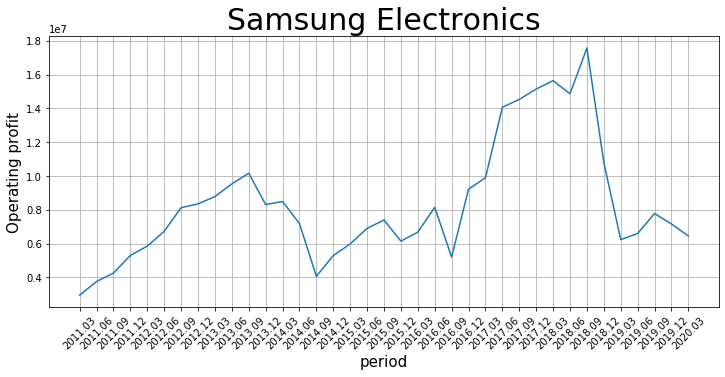

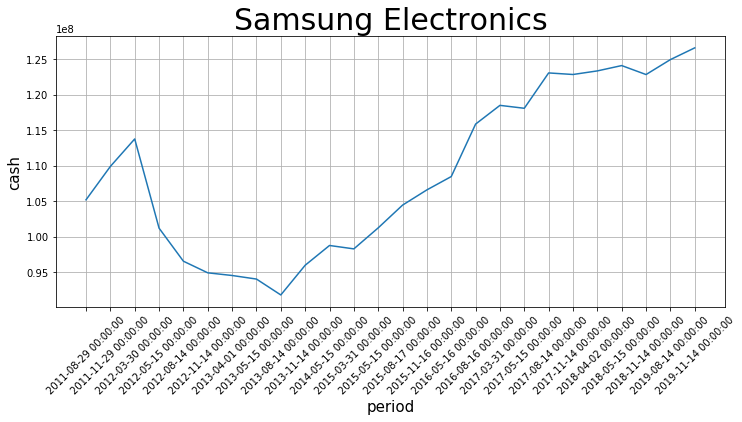

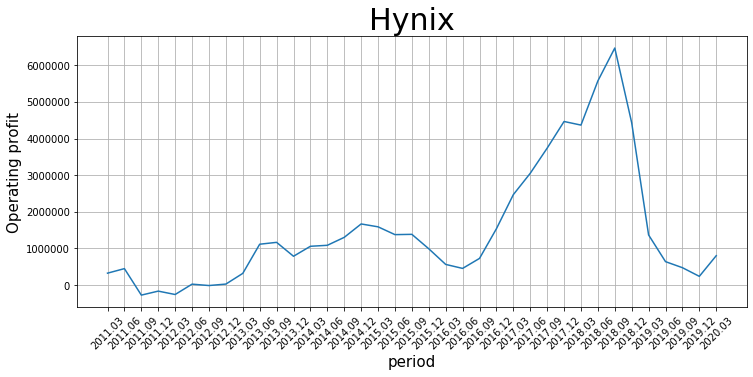

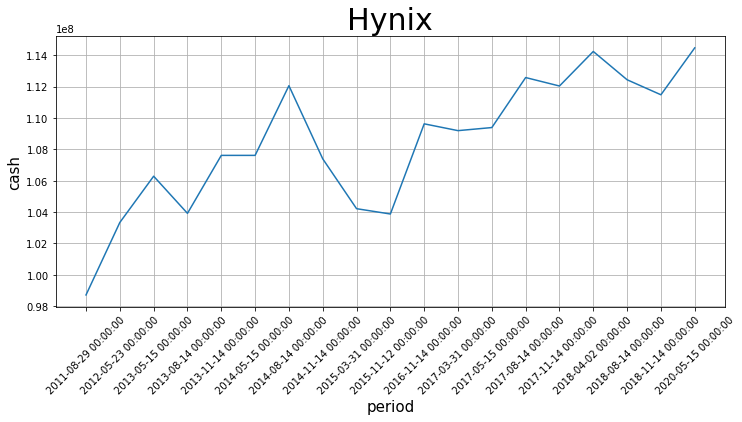

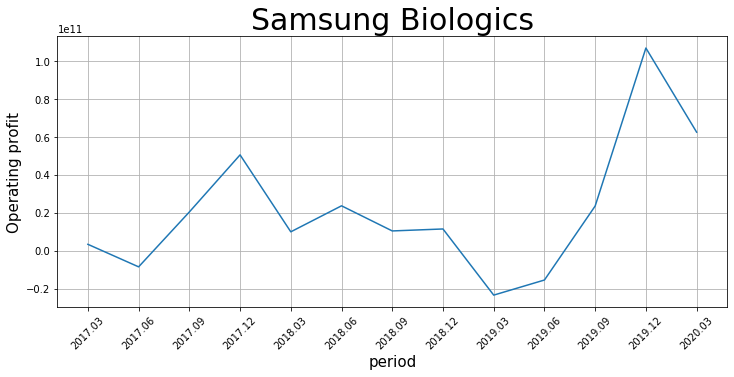

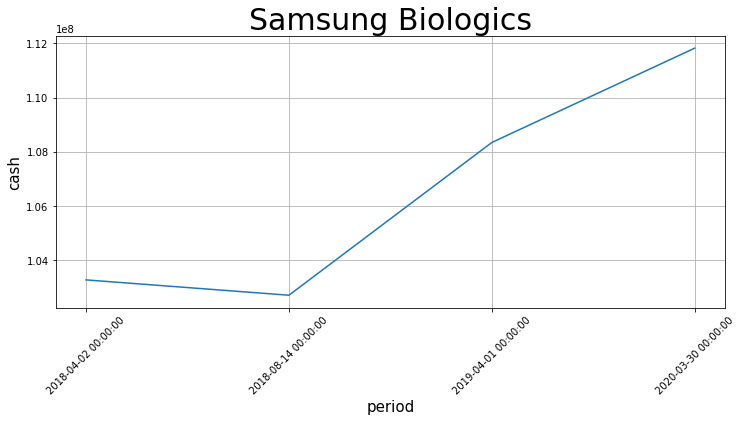

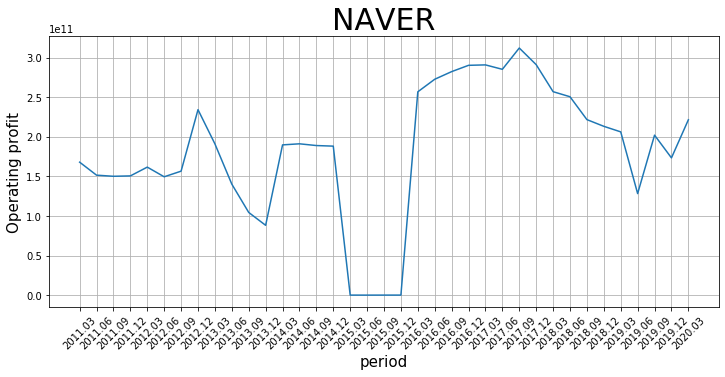

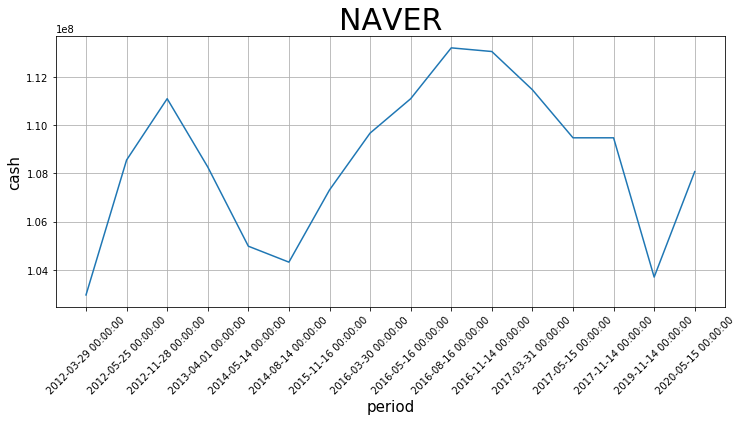

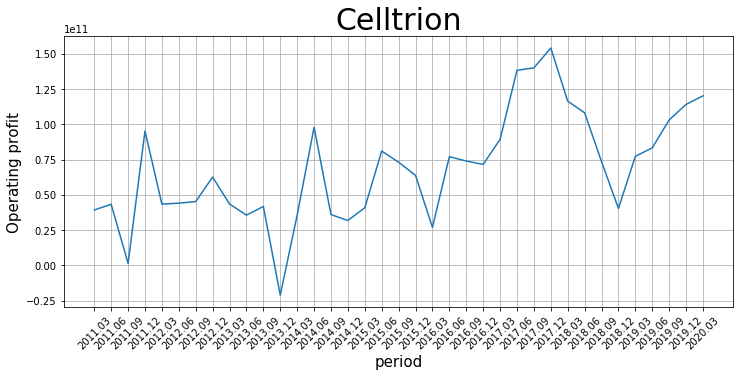

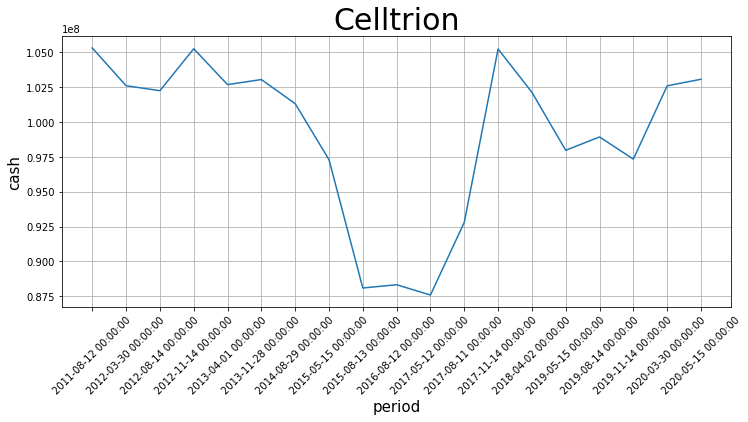

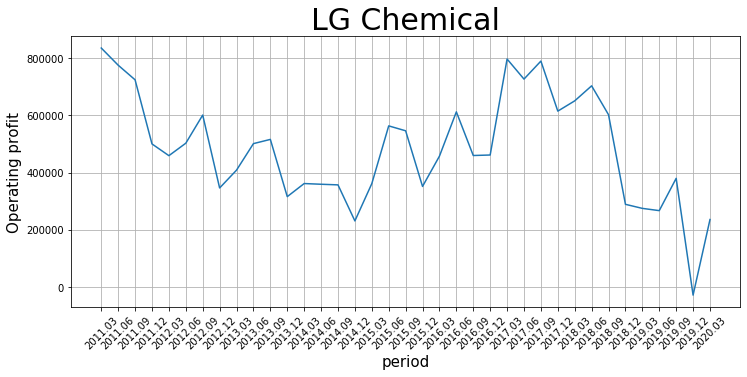

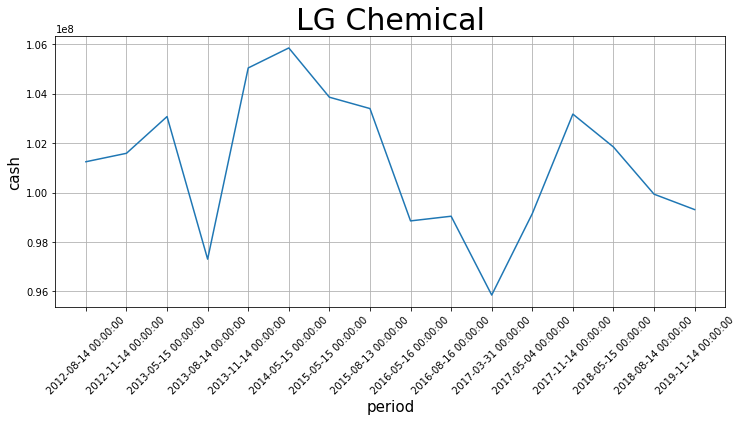

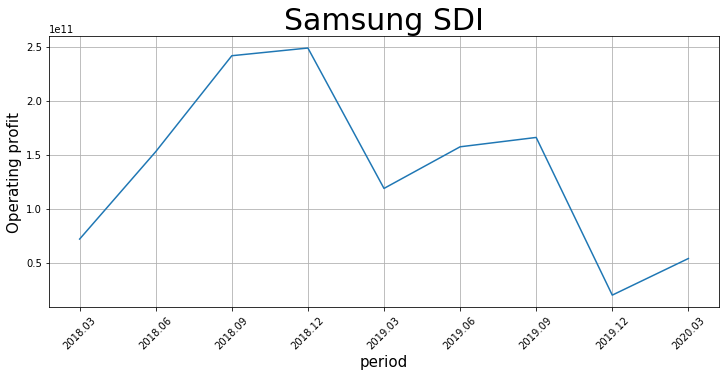

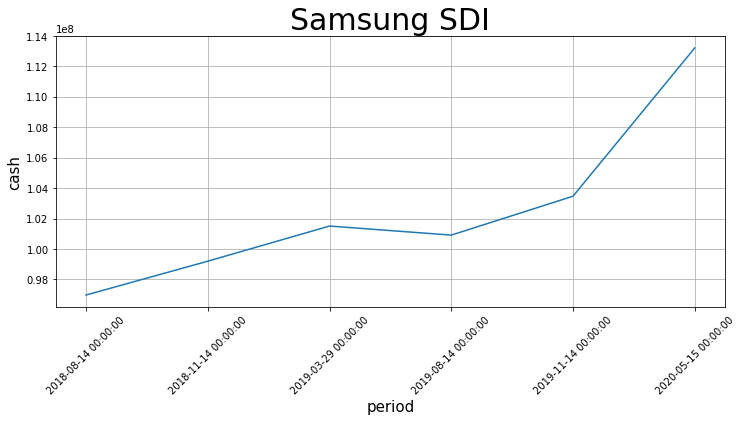

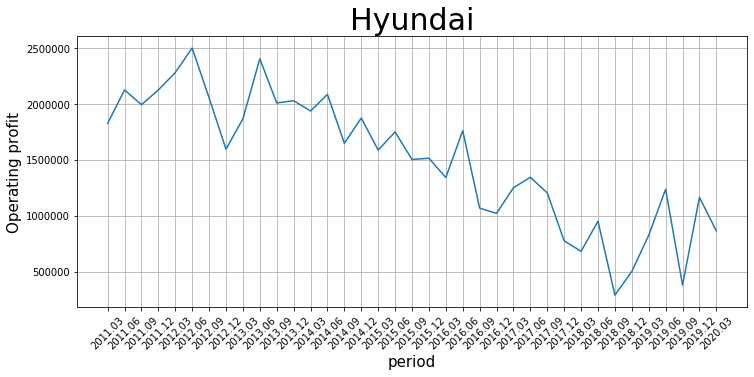

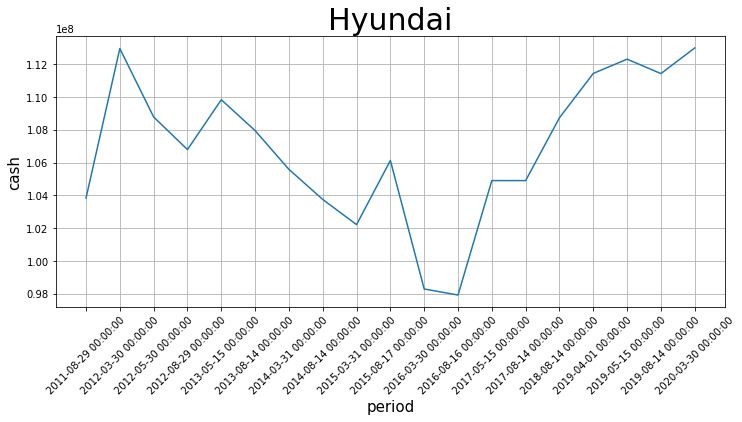

In [10]:
for corp_name, corp_num in zip(corp_name_list,corp_list):
    graph(corp_name, corp_num)

## 시사점 및 추후 진행
### 시사점
   * 종목에 따라 기간에 따라 각자 다른 결과를 나타냄 -> 상관관계를 찾기 힘듬
   * 특정 조건을 추가해서 조금더 유의미한 상관관계를 찾아볼 예정 
    * EX) 유럽재정위기 때는 실적과 상관없이 주가가 많이 하락하였는데, 이런 특정시기는 배제(?)
    
### 추후 진행
   * 사업보고서 발표날이 더 주가에 영향을 주는지 잠정실적 발표날이 더 주가에 영향을 주는지 비교
   * 단순히 시가총액 기준이 아니라 sector 별로 묶어서 수익률 확인
   * 재무재표가 잘 정리되어 있지 않은 기업은 배제하였는데, 이를 더 세밀한 전처리를 통해 종목에 포함
    